# Brecha Salarial de Género en Argentina
Este proyecto fue realizado por el grupo 15 constituido por Daniela Ferraro y Jorgelina Sigal. Se utilizó un conjunto de datos provenientes del Ministerio de Trabajo, Empleo y Seguridad Social que contiene información sobre las remuneraciones en Argentina, desagregadas por género, tipo de industria y fecha. El objetivo es analizar las brechas salariales de género y su evolución. 

### Dataset
https://www.trabajo.gob.ar/estadisticas/oede/empleoyremuneracion.asp

### Contenido del dataset
#### Periodo: 
Indica año y mes al que corresponde la remuneración.
#### Industria: 
Nombre del sector o rama de actividad económica.
#### Género: 
Género del grupo de trabajadores al que pertenece la remuneración.
#### Mujer: 
Variable binaria (1 o 0) toma el valor 1 si es mujer, 0 si no. Útil para análisis estadístico, modelos y gráficos.
#### Varon: 
Variable binaria (1 o 0) toma el valor 1 si es varón, 0 si no. Útil para análisis estadístico, modelos y gráficos.
#### Remuneración: 
Remuneración promedio mensual para ese sector, género y período (en pesos argentinos).
#### Año:
Extracción del año de la columna período.

### Objetivo general
Analizar la evolución de la remuneración media del empleo registrado en el sector privado en Argentina, según rama de actividad y género, en el período comprendido entre enero de 1996 y octubre de 2022, utilizando herramientas de data science, con el fin de identificar patrones, desigualdades y tendencias vinculadas a la brecha salarial de género en el mundo laboral.

### Objetivos específicos
- Procesar y limpiar el conjunto de datos proporcionado mediante herramientas de data science, utilizando bibliotecas como pandas para su análisis exploratorio.

- Describir la evolución temporal de la remuneración media del empleo registrado en el sector privado, diferenciando por género y rama de actividad (según el CIIU rev. 3 a dos dígitos).

- Comparar las trayectorias salariales entre varones y mujeres en los distintos sectores de actividad, identificando las ramas con mayores y menores brechas de género.

- Visualizar los resultados mediante gráficos que faciliten la comprensión de las desigualdades salariales en el período analizado.

- Aplicar un modelo de aprendizaje supervisado de regresión para predecir la remuneración media en función del género, la rama de actividad y el período, evaluando su desempeño y analizando la importancia relativa de cada variable.

- Reflexionar sobre las implicancias sociales y económicas de las desigualdades de género en el mundo laboral formal, a partir de los hallazgos del análisis de datos.

### Tecnologías
- Python 3
- Pandas
- Jupyter Notebook
- Visual Studio Code
- Matplotlib 
- Seaborn

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, f1_score
from sklearn.model_selection import GridSearchCV

## Análisis y exploración de datos

In [2]:
remuneraciones = pd.read_csv('Remuneraciones.csv', header=0, skiprows=[1])

In [3]:
# Vista general del dataset
print(remuneraciones.head())

  Periodo                Industria   Genero  Valor
0  feb-96  agricultura y ganaderia  Mujeres  406.8
1  mar-96  agricultura y ganaderia  Mujeres  399.7
2  abr-96  agricultura y ganaderia  Mujeres  375.9
3  may-96  agricultura y ganaderia  Mujeres  395.6
4  jun-96  agricultura y ganaderia  Mujeres  554.0


In [4]:
print(remuneraciones.columns)

Index(['Periodo', 'Industria', 'Genero', 'Valor'], dtype='object')


In [9]:
# Eliminar espacios en nkmbres de columnas
remuneraciones.columns = remuneraciones.columns.str.strip

TypeError: Index(...) must be called with a collection of some kind, <bound method StringMethods.strip of <pandas.core.strings.accessor.StringMethods object at 0x00000275A82952B0>> was passed

In [5]:
print(remuneraciones.columns)

Index(['Periodo', 'Industria', 'Genero', 'Valor'], dtype='object')


## Procesamiento y transformación de datos

1. Se convirtió el período a una variable numérica continua, útil para que el modelo interprete la evolución temporal y mejore la precisión.

In [6]:
# Transformacion de la columna Periodo
meses = {'ene': 1, 'feb': 2, 'mar': 3, 'abr': 4, 'may': 5, 'jun': 6,
         'jul': 7, 'ago': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dic': 12}

remuneraciones[['Mes', 'Año']] = remuneraciones['Periodo'].str.split('-', expand=True)
remuneraciones['Mes'] = remuneraciones['Mes'].map(meses)
remuneraciones['Año'] = remuneraciones['Año'].astype(int) + 1900
remuneraciones['FechaNum'] = remuneraciones['Año'] + remuneraciones['Mes'] / 12

2. Se codificó Género para convertirla en variable numérica porque los modelos de machine learning no trabajan con texto.

In [7]:
# Mujeres = 0, Varones = 1
le = LabelEncoder()
remuneraciones['Genero'] = le.fit_transform(remuneraciones['Genero'])  

3. Industria se convirtió a variable binaria, una por cada sector. Esto permite que el modelo perciba el sector económico.

In [8]:
remuneraciones = pd.get_dummies(remuneraciones, columns=['Industria'], drop_first=True)

Número de outliers en 'Valor': 5035


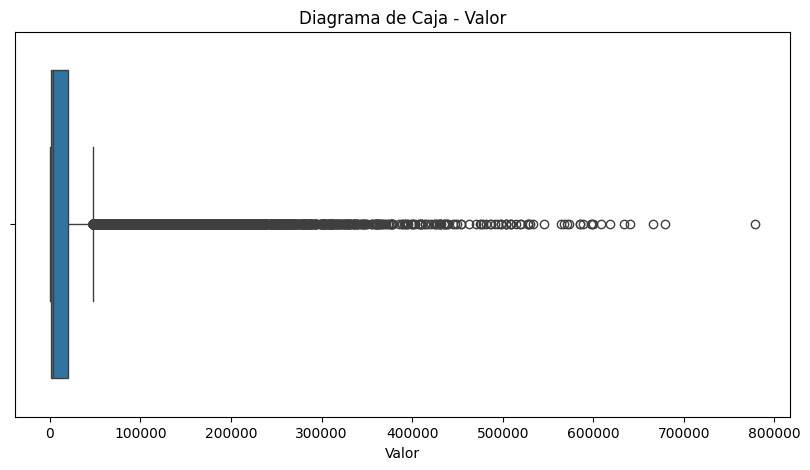

In [40]:
columna = 'Valor'

# Cálculo del IQR
Q1 = remuneraciones[columna].quantile(0.25)
Q3 = remuneraciones[columna].quantile(0.75)
IQR = Q3 - Q1

# Límites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar outliers
outliers = remuneraciones[(remuneraciones[columna] < limite_inferior) | (remuneraciones[columna] > limite_superior)]
print(f"Número de outliers en '{columna}':", outliers.shape[0])

# Visualización
plt.figure(figsize=(10,5))
sns.boxplot(x=remuneraciones[columna])
plt.title(f'Diagrama de Caja - {columna}')
plt.show()

In [9]:
#Separar X e y
X = remuneraciones.drop(columns=['Periodo', 'Genero', 'Mes', 'Año'])
y = remuneraciones['Genero']

4. Se escaló Valor y FechaNum para que tengan igual peso. Esto es importante porque los modelos como Random Forest no se ven afectados, pero otros sí lo necesitan.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train[['Valor', 'FechaNum']] = scaler.fit_transform(X_train[['Valor', 'FechaNum']])
X_test[['Valor', 'FechaNum']] = scaler.transform(X_test[['Valor', 'FechaNum']])

In [27]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=5,class_weight='balanced', random_state=42)
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,                 # limitar profundidad de los árboles
    min_samples_split=10,        # mínimo de muestras para dividir
    min_samples_leaf=5,          # hojas con mínimo de muestras
    max_features='sqrt',         # menos variables al dividir
    class_weight='balanced',     # ajusta por clases desbalanceadas
    random_state=42,
    n_jobs=-1
)

In [32]:
model.fit(X_train, y_train)

# Evaluación
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Métricas
print("Accuracy train:", accuracy_score(y_train, y_pred_train))
print("Accuracy test:", accuracy_score(y_test, y_pred_test))
print("F1-score test:", f1_score(y_test,y_pred_test))


Accuracy train: 0.6117146262557467
Accuracy test: 0.566058294742577
F1-score test: 0.6566070273765898


In [34]:
scores = cross_val_score(model, X_train, y_train, cv=5)
print("CV accuracy promedio:", scores.mean())

CV accuracy promedio: 0.5666950451217436


In [36]:
y_pred = model.predict(X_test)

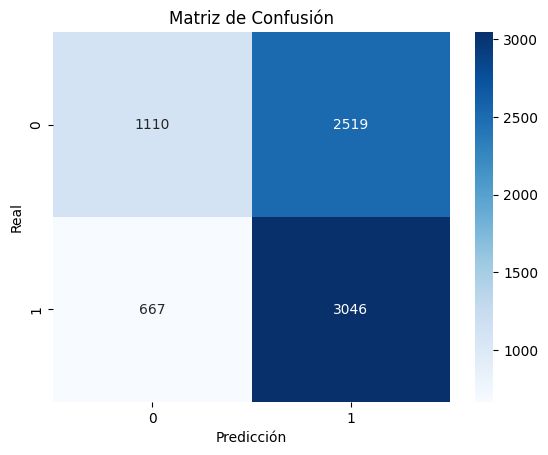

In [37]:
# Matriz de confusion
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

Los resultados arrojaron:
- 1110 (Verdaderos Negativos - TN)

- 3046 (Verdaderos Positivos - TP)

- 2519 (Falsos Positivos - FP)

- 667 (Falsos Negativos - FN)

- Alto recall (0.82): El modelo es bueno detectanto los casos positivos (clase 1), lo cual es útil si la prioridad es minimizar los falsos negativos, en este caso para no perder casos importantes.

- Baja precisión (0.54): Muchos de los que predice como positivos no lo son realmente. Hay muchos falsos positivos.

- Accuracy baja (0.56): El modelo no clasifica corectamente una gran parte del conjunto.

- F1-score aceptable (0.65): Refleja u balance aceptable entre precisión y recall, pero podría mejorarse.

Se concluye que: 

- El modelo intenta aprender patrones en los salarios según sector y período para adivinar si la persona es hombre o mujer.

- El hecho de que logre una precisión del 70% sugiere que hay una brecha salarial y/o patrones diferenciados entre géneros que el modelo está captando, pero no de forma determinista (no puede distinguir con certeza absoluta).

- El modelo tiene una precisión general del 70% aproximadamente. El desempeño es bastante equilibrado entre ambas clases, aunque hay una cantidad no menor de errores (más de 1000 falsos positivos y más de 1000 falsos negativos). Se podría explorar mejoras ajustando el umbral de decisión o probando otro modelo.


## Conclusión
El objetivo de este trabajo fue responder a la pregunta:
¿Es posible predecir el género de una persona a partir de su remuneración?

Desde el comienzo, se sostuvo una postura crítica:
*Predecir el género a partir del salario y otras variables económicas puede reforzar estereotipos de género y perpetuar sesgos estructurales existentes. Por ello, esta tarea no debe ser utilizada para decisiones reales sobre individuos, sino como una herramienta de análisis exploratorio que permita visibilizar desigualdades.*

Con esta perspectiva, el equipo decidió construir un modelo de clasificación que permitiera poner en práctica los contenidos del curso y cerrar el proyecto con un ejercicio técnico-aplicado.

Los resultados obtenidos reflejan que el modelo logra una predicción algo mejor que el azar, pero con limitaciones evidentes en cuanto a generalización y precisión. Si bien es técnicamente posible detectar patrones asociados al género en función de variables como la remuneración, esto en sí mismo es un indicio de la persistencia de brechas salariales y sesgos estructurales.

Más allá de la performance del modelo, este ejercicio deja en evidencia que el salario y otras variables laborales están correlacionadas con el género, lo cual no debería suceder en un sistema justo e igualitario.
Utilizar herramientas de ciencia de datos en este contexto permite no solo entrenar modelos, sino también generar conciencia sobre las desigualdades que los datos reflejan.